In [1]:
import numpy as np
from tqdm import tqdm
import torch

from util.mccc import MCCCPicker
from util import transforms
import util.reader as io
from util import DASplot

## Download data

In [2]:
from urllib.request import urlretrieve
url = 'https://data.caltech.edu/records/n47vy-s0s65/files/DASPphaseData.tar?download=1'
urlretrieve(url, './data/phase.tar')
# unzip this tar file

## Event phase data

read event data: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


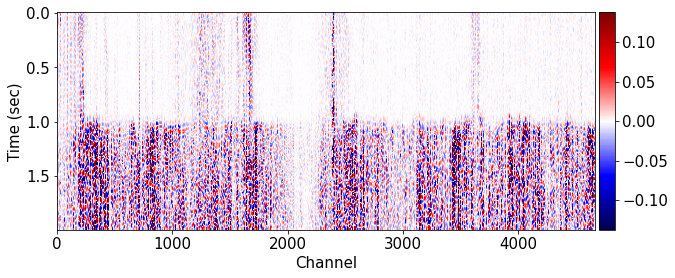

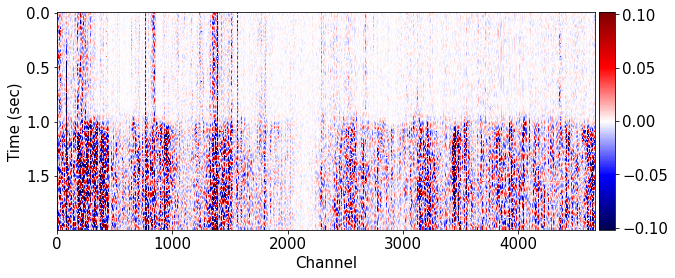

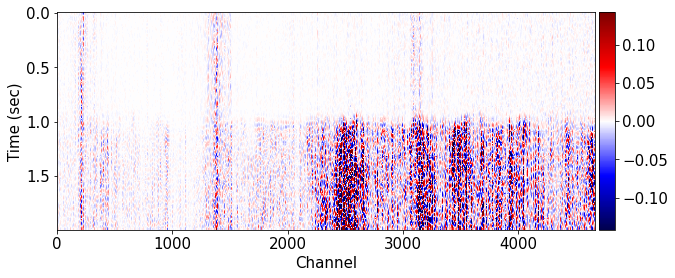

In [3]:
path_event_phase = './data/CaltechDATA/phase_P'
# example events in Long Valley
event_id_list = [73581381, 73539650, 73560520]

tempP_list = []
tempP_info_list = []
for event_id in tqdm(event_id_list, desc="read event data"):
    data, info = io.read_das_eventphase_data_h5(f'{path_event_phase}/{event_id}.h5')
    tempP_list.append(data[0])
    tempP_info_list.append(info[0])
    fig, ax = DASplot.show_das_data(
        data[0], info[0], figsize=(10, 4)
    )
    ax.set_ylabel("Time (sec)")

## Cross-correlation

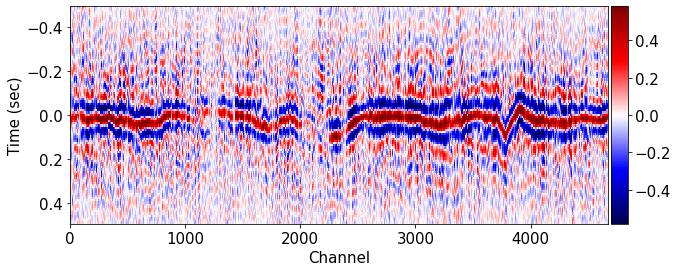

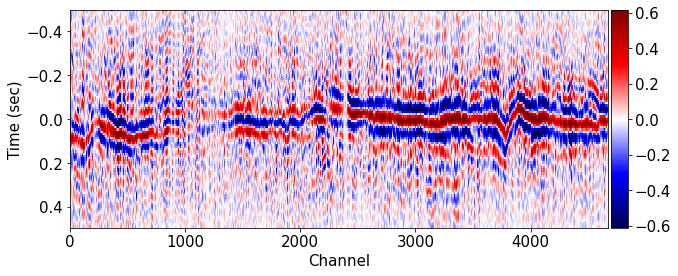

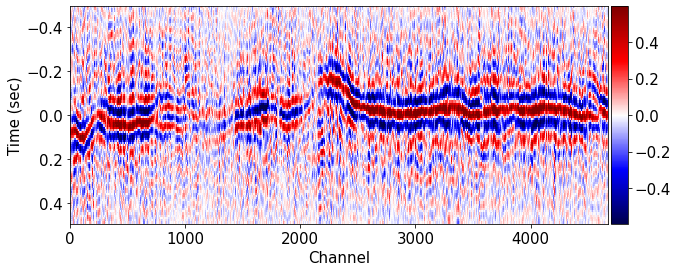

In [4]:
# %% cross-correlation between the P phases
xcor_list = []
xcor_info_list = []
for i, event_id_i in enumerate(event_id_list):
    for j, event_id_j in enumerate(event_id_list):
        if j <= i:
            continue
        a = torch.tensor(tempP_list[i])
        b = torch.tensor(tempP_list[j])
        a[:] = transforms.taper_time(a)
        b[:] = transforms.taper_time(b)
        xcor, xcor_info = transforms.xcorr_freq(a, b, 1 / 100, maxlag=0.5)
        fig, ax = DASplot.show_cc2d_data(
            transforms.moving_average(xcor, 10), xcor_info, figsize=(10, 4)
        )
        ax.set_ylabel("Time (sec)")
        title = f"{event_id_i}_{event_id_j}"
        xcor_info["event_id1"] = event_id_i
        xcor_info["event_id2"] = event_id_j
        xcor_list.append(xcor)
        xcor_info_list.append(xcor_info)

## MCCC picking

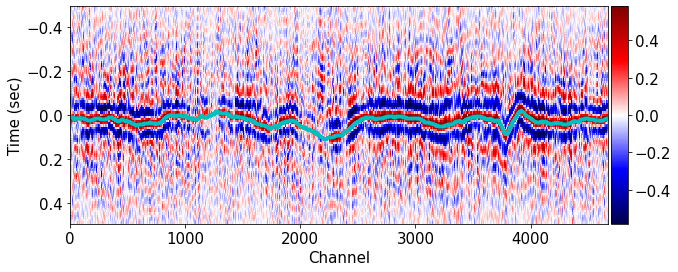

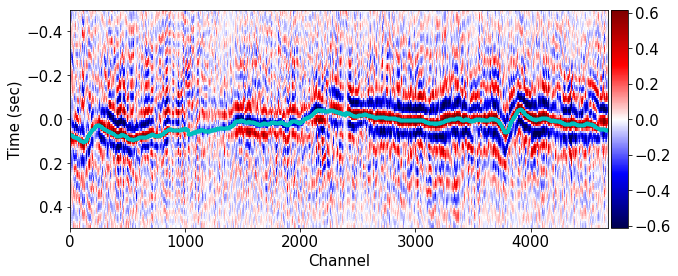

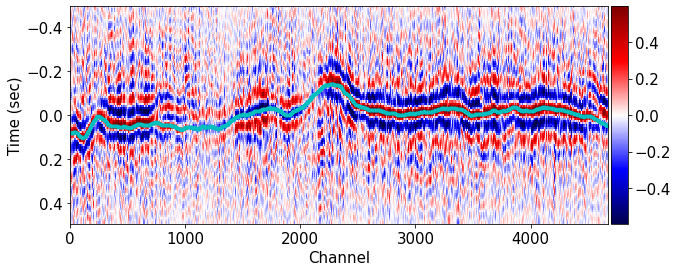

In [5]:
for i, xcor in enumerate(xcor_list):
    mp = MCCCPicker(xcor, 1 / 100, mccc_maxwin=10, damp=0, mccc_damp=1.0)
    sol = mp.solve()
    fig, ax = DASplot.show_cc2d_data(
        transforms.moving_average(xcor, 10), xcor_info, figsize=(10, 4)
    )
    ax.scatter(np.arange(len(sol["cc_dt"])), sol["cc_dt"], s=5, c="c")
    event_id1 = xcor_info_list[i]["event_id1"]
    event_id2 = xcor_info_list[i]["event_id2"]

## Polarity inversion

In [6]:
# relative polarity matrices: 
# Ckij cc between two events at the same channel
# Skij cc between two events at adjacent channels
dat = np.load('./data/longvalley_25events_relative_polarity.npz')
Ckij = dat['Ckij']
Skij = dat['Skij']
Pkic, Pkic_info = transforms.Pkic_from_Ckij_Skij(torch.tensor(Ckij), torch.tensor(Skij))

100%|██████████| 4670/4670 [00:02<00:00, 2242.10it/s]


(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

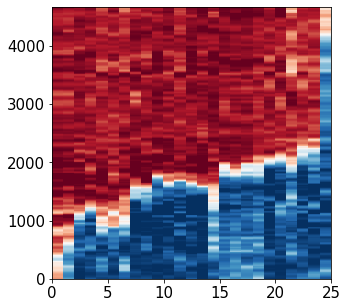

In [7]:
DASplot.show_polarity_matrix(-Pkic, perc=90) # -1 determined from conventional seismometer